In [1]:
import lightning as L
from data.dataset import Dataset
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from src.model import Q_model
from lightning.pytorch.callbacks import ModelCheckpoint
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import numpy as np
import logging

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [2]:
def plot_distribution_metrics(distrib, mu_1, mu_2, name):
    print("Interval width: ", mu_2 - mu_1)
    print("Coverage : ", np.mean((distrib > mu_1) & (distrib < mu_2)))
    plt.hist(distrib, bins=100, label=name)
    plt.axvline(mu_1, color='r', label='mu_1')
    plt.axvline(mu_2, color='r', label='mu_2')
    plt.legend()
    plt.show()

In [3]:
# Experiment parameters
random_seed = 0
device = 0
test_ratio = 0.2
coverage = 0.8
dropout = 0.0
epochs = 300
size = 10000
batch_size = size

In [4]:
#Gaussian distribution parameters
mean = 0
std = 0.1

#Sampling from Gaussian distribution
L.pytorch.seed_everything(random_seed, workers=True)
y = np.array(norm.rvs(size=size, loc=mean, scale=std, random_state=random_seed)).reshape(-1, 1)
noise = np.array(norm.rvs(size=size, loc=0, scale=0.0001, random_state=random_seed)).reshape(-1, 1)
X = 1 + noise

#Splitting Gaussian dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_ratio, random_state=random_seed)

train_dataset = Dataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = Dataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = Dataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, persistent_workers=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, persistent_workers=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, persistent_workers=True, num_workers=2)

Seed set to 0


Interval width:  0.2536165
Coverage :  0.7968


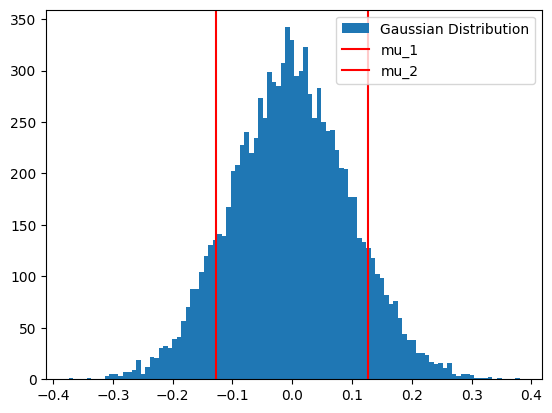

In [5]:
#Train model with WS loss on Gaussian dataset
loss = "WS"
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", logger=False, deterministic=True, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Gaussian Distribution")


/home/tp531/miniconda/envs/test_rqr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Interval width:  0.25532618
Coverage :  0.7989


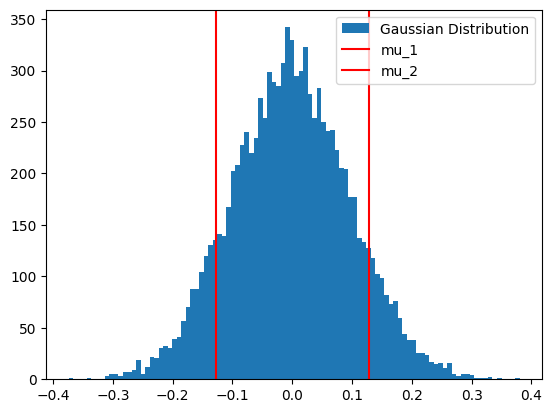

In [6]:
#Train model with WS loss on Gaussian 

loss = "RQR-W"
penalty = 0
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss, penalty=penalty)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", deterministic=False, logger=False, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Gaussian Distribution")


Interval width:  0.255454
Coverage :  0.7992


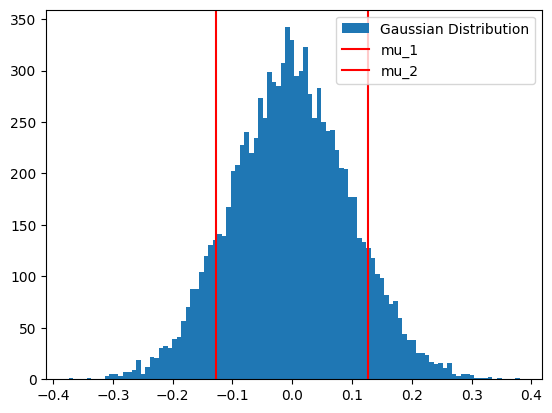

In [7]:
#Train model with RQR loss on Gaussian dataset
loss = "RQR-W"
penalty = 10
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss, penalty=penalty)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", deterministic=False, logger=False, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Gaussian Distribution")


In [8]:
#Truncated Gaussian distribution parameters
mean = 0
std = 1
a = -0.1
b = 5

#Sampling from Gaussian distribution
L.pytorch.seed_everything(random_seed, workers=True)
y = np.array(truncnorm.rvs(size=size, loc=mean, scale=std, a=a, b=b, random_state=random_seed)).reshape(-1, 1)
noise = np.array(norm.rvs(size=size, loc=0, scale=0.0001, random_state=random_seed)).reshape(-1, 1)
X = 1 + noise

#Splitting Gaussian dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_ratio, random_state=random_seed)

train_dataset = Dataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = Dataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = Dataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, persistent_workers=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, persistent_workers=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, persistent_workers=True, num_workers=2)

[[0.02868945 1.6039782 ]
 [0.02868945 1.6039782 ]
 [0.02868945 1.6039782 ]
 ...
 [0.02868945 1.6039782 ]
 [0.02868945 1.6039782 ]
 [0.02868945 1.6039782 ]]
Interval width:  1.5752887
Coverage :  0.8031


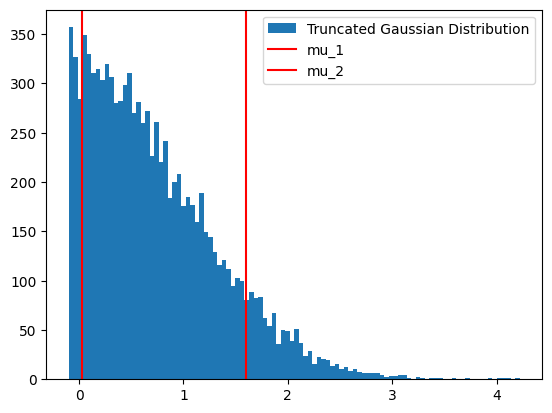

In [9]:
#Train model with WS loss on Truncated Gaussian dataset
loss = "WS"
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", logger=False, deterministic=True, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

print(y_hat)

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Truncated Gaussian Distribution")

/home/tp531/miniconda/envs/test_rqr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Interval width:  1.7160449
Coverage :  0.8059


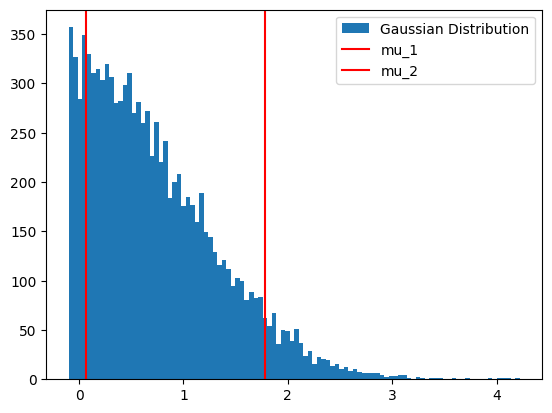

In [10]:
#Train model with RQR loss on Truncated Gaussian dataset
loss = "RQR-W"
penalty = 0
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss, penalty=penalty)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", deterministic=False, logger=False, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Gaussian Distribution")


Interval width:  1.4816232
Coverage :  0.8025


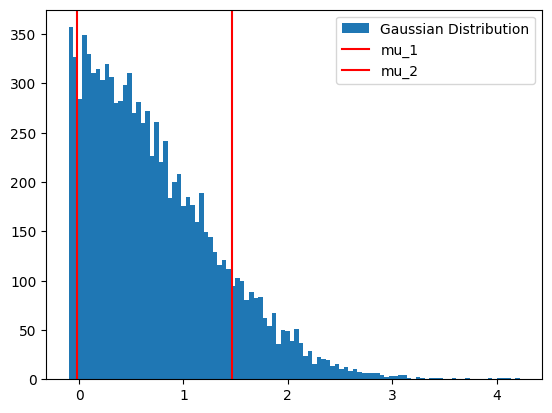

In [11]:
#Train model with RQR-W loss on Truncated Gaussian dataset
loss = "RQR-W"
penalty = 20
lr = 0.1

#Load model
model = Q_model(coverage=coverage, x_shape=X_train.shape[1], hidden_size=64, dropout=dropout, lr=lr, loss = loss, penalty=penalty)

#Train model
trainer = L.Trainer(max_epochs=epochs,  devices = [device], accelerator="gpu", deterministic=False, logger=False, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

#Test model    
y_hat = trainer.predict(model, test_loader)[0].cpu().numpy()

plot_distribution_metrics(y, min(y_hat[0][0], y_hat[0][1]), max(y_hat[0,0], y_hat[0,1]), "Gaussian Distribution")
